Take-home Unsupervised Learning

In [1]:
import os
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
fname = join(os.getcwd(),'data','data3SS2009.mat') #carrega o arquivo com um dicionário contendo todas as informações
mat_contents = sio.loadmat(fname) #mat_contents é do tipo dict
dataset = mat_contents['dataset'] #na chave 'dataset' estão as informações de entrada que serão tratadas e inseridas no modelo
N, Chno, Nc = dataset.shape

# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc) #na chave 'labels' do dict estão as saidas num array

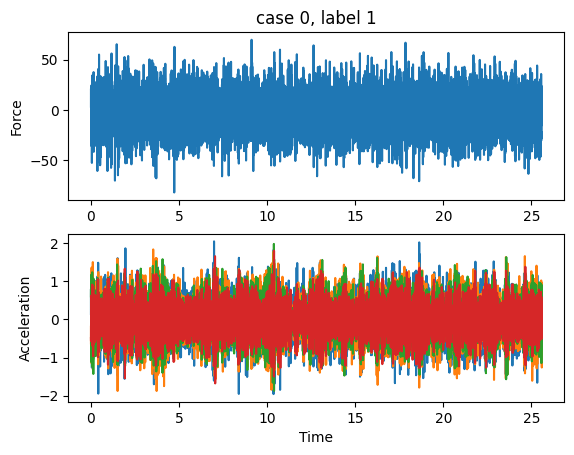

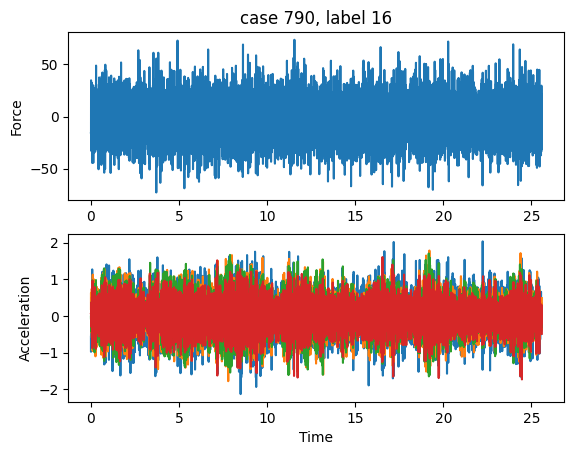

In [3]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [4]:
#Etapa de pre-processamento (AR)

Ch2_ar = np.empty((850,30), float)
Ch3_ar = np.empty((850,30), float)
Ch4_ar = np.empty((850,30), float)
Ch5_ar = np.empty((850,30), float)

for i in range(0,850):
    res2 = AutoReg(Ch2[:,i], lags = 30).fit()
    res3 = AutoReg(Ch3[:,i], lags = 30).fit()
    res4 = AutoReg(Ch4[:,i], lags = 30).fit()
    res5 = AutoReg(Ch5[:,i], lags = 30).fit()
    
    for j in range(0,30):
        Ch2_ar[i,j] = res2.params[1:31][j]
        Ch3_ar[i,j] = res3.params[1:31][j]
        Ch4_ar[i,j] = res4.params[1:31][j]
        Ch5_ar[i,j] = res5.params[1:31][j]

In [9]:
Ch2_ar.shape

(850, 30)

In [10]:
X1=np.concatenate((Ch2_ar, Ch3_ar), axis=1)
X1=np.concatenate((X1, Ch4_ar), axis=1)
X1=np.concatenate((X1, Ch5_ar), axis=1)
X1.shape

(850, 120)

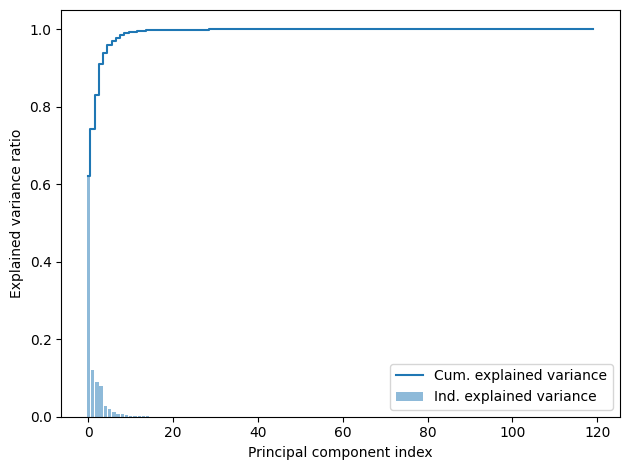

(850, 10)

In [53]:
#Etapa de pre-processamento (PCA)

pca = PCA()
pca.fit(X1)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

X1_reduced=pca.fit_transform(X1)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
X2=X1_reduced[:,0:componentes]
X2.shape

In [54]:
#Ajustando a escala das saidas X1 e X2 para -1 a 1:

scaler = MinMaxScaler(feature_range=(-1,1))
X1s = scaler.fit_transform(X1)
X2s = scaler.fit_transform(X2)

In [55]:
import numpy as np
from scipy import stats
from scipy.stats import mode
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [56]:
X2[:,0:3].shape

(850, 3)

In [57]:
kmeans = KMeans(n_clusters = 17, random_state = 0).fit(X2s[:,0:3])
y_pred = kmeans.predict(X2s[:,0:3])

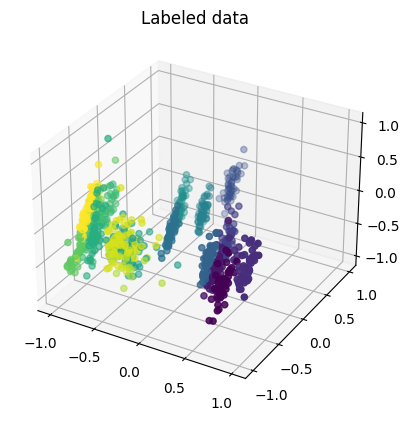

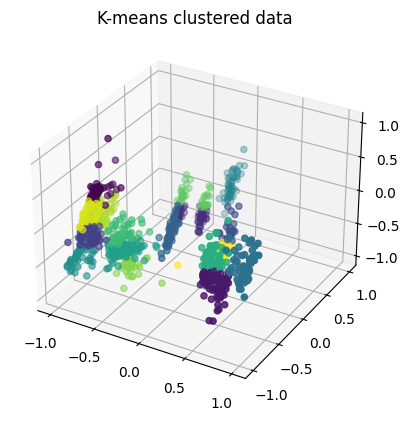

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig1 = plt.figure()
axs1 = plt.axes(projection ='3d')

axs1.scatter(X2s[:, 0], X2s[:, 1], X2s[:, 2], c=y)
axs1.set_title("Labeled data")

fig2 = plt.figure()
axs2 = plt.axes(projection ='3d')

axs2.scatter(X2s[:, 0], X2s[:, 1], X2s[:, 2], c=y_pred)
axs2.set_title("K-means clustered data")

plt.show()

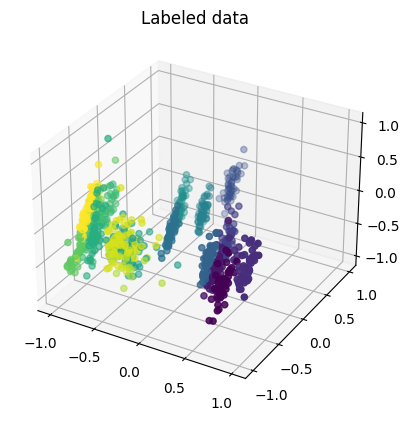

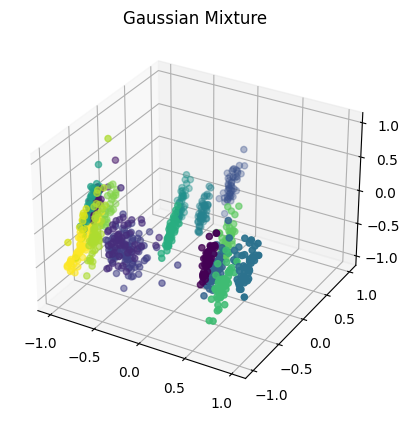

In [74]:
from sklearn.mixture import GaussianMixture

y_pred_2 = GaussianMixture(n_components=17).fit_predict(X2s)

fig3 = plt.figure()
axs3 = plt.axes(projection ='3d')

axs3.scatter(X2s[:, 0], X2s[:, 1], X2s[:, 2], c=y)
axs3.set_title("Labeled data")

fig4 = plt.figure()
axs4 = plt.axes(projection ='3d')

axs4.scatter(X2s[:, 0], X2s[:, 1], X2s[:, 2], c=y_pred_2)
axs4.set_title("Gaussian Mixture")

plt.show()

In [75]:
y_status = (y>=10).astype(int)

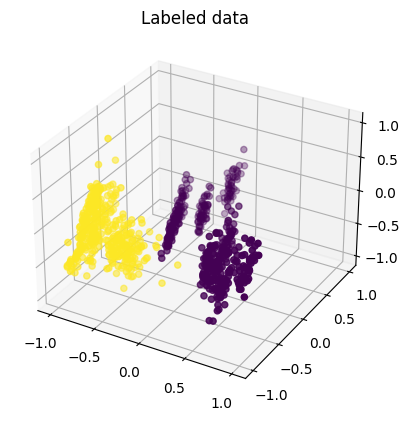

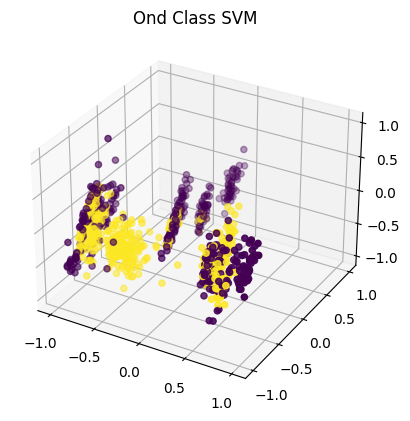

In [76]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma='auto').fit(X2s)
y_pred_3 = clf.predict(X2s)

fig5 = plt.figure()
axs5 = plt.axes(projection ='3d')

axs5.scatter(X2s[:, 0], X2s[:, 1], X2s[:, 2], c=y_status)
axs5.set_title("Labeled data")

fig6 = plt.figure()
axs6 = plt.axes(projection ='3d')

axs6.scatter(X2s[:, 0], X2s[:, 1], X2s[:, 2], c=y_pred_3)
axs6.set_title("Ond Class SVM")

plt.show()

In [77]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X1)
X_embedded.shape

(850, 3)

Text(0.5, 0.92, 't-SNE')

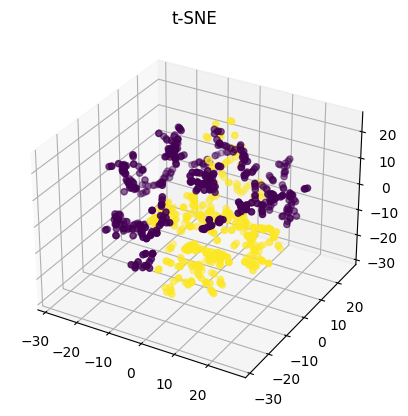

In [79]:
fig7 = plt.figure()
axs7 = plt.axes(projection ='3d')

axs7.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y_status)
axs7.set_title("t-SNE")